In [1]:
import numpy as np
def kmeans_numpy(X, n_clusters, max_iters=100):

    """
    Hint:
    if implementing using numpy array:
    the shape of the centroids are (n_clusters x 2 ), a 2D array--> each cluster is has a coordinate with makes it a 2 value
    The shape of the labels are (for the given sample image) 512 x 512 = 262144 --> a 1D array
    """
    # Initialize cluster centroids randomly
    centroids = X[np.random.choice(len(X), n_clusters, replace=False)]
    labels = np.zeros(X.shape[0])
    for _ in range(max_iters):
        # for i in range(X.shape[0]):
        #     distances = np.linalg.norm(X[i] - centroids, axis=1)
        #     labels[i] = np.argmin(distances)
        
        #rewrite the for loop
        distances = np.linalg.norm(X[:,np.newaxis]-centroids, axis= 2)
        labels =  np.argmin(distances,axis=1)

        new_centroids = np.zeros((n_clusters, X.shape[1]))

        for k in range(n_clusters):
            cluster_points = X[labels == k]
            
            new_centroids[k] = np.mean(cluster_points, axis=0)
            
        if np.all(centroids == new_centroids):
            break

        centroids = new_centroids

    return centroids, labels

In [2]:
def create_compressed_image(labels, centroids, height, width, channels):
    """
    Hint:
    Assign the cluster value to the pixel of that cluster
    """
    # Step 3: Create a compressed image based on cluster centroids
    compressed_image = np.zeros((height, width, channels), dtype=np.uint8)

    label_idx = 0
    for i in range(height):
        for j in range(width):
            cluster_label = labels[label_idx]
            compressed_image[i, j] = centroids[int(cluster_label)]
            label_idx += 1

    return compressed_image

Original image size: 521129 bytes
Compressed image size: 255514 bytes
Compression ratio: 2.04


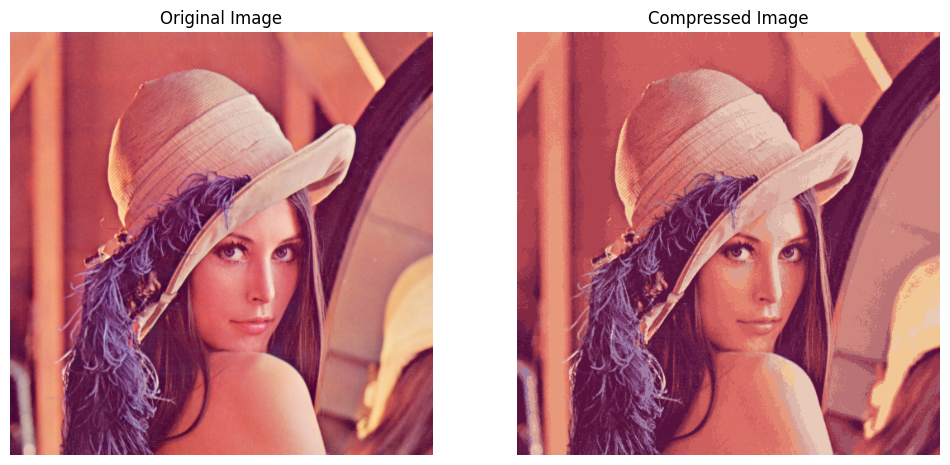

In [3]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def kmeans_image_compression(image_path, num_clusters):
    # Step 1: Load the image
    original_image = cv2.imread(image_path)

    # Convert the image to RGB color space (if it's not already)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Get the dimensions of the image
    height, width, channels = original_image.shape

    # Step 2: Apply K-means clustering using numpy
    pixel_values = original_image.reshape(-1, 3)
    centroids, labels = kmeans_numpy(pixel_values, num_clusters)

    # Step 3: Create a compressed image based on cluster centroids
    compressed_image = create_compressed_image(labels, centroids, height, width, channels)

    # Step 4: Save the compressed image
    compressed_image_path = "compressed_image.png"
    cv2.imwrite(compressed_image_path, cv2.cvtColor(compressed_image, cv2.COLOR_RGB2BGR))

    # Save the original image in the same format as the compressed one
    original_image_path = "original_image.png"
    cv2.imwrite(original_image_path, cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR))

    # Calculate and print the compression ratio
    original_size = os.path.getsize(original_image_path)
    compressed_size = os.path.getsize(compressed_image_path)
    compression_ratio = original_size / compressed_size

    print(f"Original image size: {original_size} bytes")
    print(f"Compressed image size: {compressed_size} bytes")
    print(f"Compression ratio: {compression_ratio:.2f}")

    # Show the original and compressed images using matplotlib
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(compressed_image)
    plt.title("Compressed Image")
    plt.axis("off")

    plt.show()

if __name__ == "__main__":
    image_path = "test_image.png"

    num_clusters = 20  # Adjust the number of clusters as needed
    kmeans_image_compression(image_path, num_clusters)


If increasing the number of clusters, the compression rate will rise as the compressed image size drop. Of course, the run time of the code will rise as well.

Part b:

In this part, each entry in an array represents each row in a matrix in the equations.
All the entities are in bold.

Step1:
Get the dimentions of image as in starter code.
height, width, channels = original_image.shape

Step2:
Need to reshape the  image to X for processing with GMM.
Where **X**:(height*width, channels).
This creates a matrix where each row corresponds to a pixel and each column represents a color channel.

Step3:
Decide on the number of Gaussian components to use: K
And initialize the GMM parameters.
$\theta = (m_{1:K}, \mu_{1:K}, C_{1:K} )$
Where 
**$m_i$** is the prior probability of each cluster, so $\sum_k m_k = 1$
And 

**$\mu_i$** is the mean color vector with dimension of (1,channels)$

**$C_i$** is the cov matrix with dimensions (channels, channels).

Step4: run the EM algorithm.
E-Step:
for each data point i (row in X) do:
$ \gamma_{i,j} = \frac {m_j*G(X_i;\mu_i,C_j)}{\sum_K m_k*G(X_i;\mu_k,C_k)} $
Where G is the Probability density function of a Gaussian distribution

M-Step:
for each cluster j do
$m_j = \frac{\sum_i \gamma_{i,j}}{N}$

$\mu_j = \frac{\sum_i \gamma_{i,j}*X_i}{\sum_i \gamma_{i,j}}$

$C_j = \frac{\sum_i \gamma_{i,j} (X_i - \mu_j)(X_i - \mu_j)^T}{\sum_i \gamma_{i,j}}$

Where **N** is the number of Rows in X which is height * width

Step5:
After the GMM converged, we will obtain the **labels** list with dimension (height*width).

for each data point i (row in X) do:
$ \gamma_{i,j} = \frac {m_j*G(X_i;\mu_i,C_j)}{\sum_K m_k*G(X_i;\mu_k,C_k)} $

Where G is the Probability density function of a Gaussian distribution.

find the value j with highest $\gamma_{i,j}$ value and assign the point to cluster j, which means update the correspond position in labels list with value j.

Step6:
Follow the same logic, create the **compressed_image** with dimensions (height*width, channels). 

To be specific,
for every entry i in labels,
update  compressed_image[i]=$\mu$[labels[i]]

Then, we can save the compressed_image in png format using cv2.imwrite()